<a href="https://colab.research.google.com/github/vishakha1221/datascience-practical/blob/main/music_recomender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "music (2).csv"
df = pd.read_csv(file_path)

In [47]:
# Data preprocessing
df = df.drop(columns=['Unnamed: 0'], errors='ignore')  # Remove unnamed column if exists
df.drop_duplicates(subset=['song_title', 'artist'], inplace=True)

In [48]:
# Select features for recommendation
features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
feature_matrix = df[features]

In [49]:
#from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)


In [50]:
# Apply K-means clustering to group similar songs (e.g., genres/styles)
n_clusters = 10  # Adjust based on dataset size
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(feature_matrix_scaled)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(feature_matrix_scaled)
# from sklearn.metrics.pairwise import cosine_similarity

# similarity_matrix = cosine_similarity(feature_matrix_scaled)

In [51]:
'''def recommend_songs(song_title, top_n=5):
    if song_title not in df['song_title'].values:
        return "Song not found."

    index = df[df['song_title'] == song_title].index[0]
    similarity_scores = list(enumerate(similarity_matrix[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_songs = similarity_scores[1:top_n+1]

    recommendations = df.iloc[[i[0] for i in top_songs]][['song_title', 'artist']]
    return recommendations'''


'def recommend_songs(song_title, top_n=5):\n    if song_title not in df[\'song_title\'].values:\n        return "Song not found."\n\n    index = df[df[\'song_title\'] == song_title].index[0]\n    similarity_scores = list(enumerate(similarity_matrix[index]))\n    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)\n    top_songs = similarity_scores[1:top_n+1]\n\n    recommendations = df.iloc[[i[0] for i in top_songs]][[\'song_title\', \'artist\']]\n    return recommendations'

In [52]:
#recommend_songs("Mask Off")

In [53]:
# Enhanced recommendation function
def recommend_songs(song_title, artist=None, top_n=5, use_target=True, same_cluster=True, same_artist_weight=0.2):
    """
    Recommend songs based on audio features, clustering, and artist similarity.

    Parameters:
    - song_title: Title of the input song
    - artist: Artist of the input song (optional, for disambiguation)
    - top_n: Number of recommendations to return
    - use_target: If True, prioritize songs with target=1 (liked)
    - same_cluster: If True, prioritize songs in the same cluster
    - same_artist_weight: Weight for boosting same-artist songs
    """
    # Find the song
    mask = df['song_title'] == song_title
    if artist:
        mask &= df['artist'] == artist
    matching_songs = df[mask]

    if matching_songs.empty:
        return f"❌ Song '{song_title}' not found in dataset."

    if len(matching_songs) > 1 and not artist:
        return f"Multiple songs named '{song_title}' found. Please specify the artist."

    idx = matching_songs.index[0]
    input_cluster = df.loc[idx, 'cluster']

    # Get similarity scores
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Adjust scores based on artist and cluster
    for i, score in sim_scores:
        if df.iloc[i]['artist'] == df.iloc[idx]['artist']:
            sim_scores[i] = (i, score + same_artist_weight)  # Boost same artist
        if same_cluster and df.iloc[i]['cluster'] != input_cluster:
            sim_scores[i] = (i, score * 0.5)  # Penalize different clusters

    # Sort by similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Filter by target if specified
    if use_target:
        recommended = df.iloc[[i[0] for i in sim_scores]][['song_title', 'artist', 'target', 'cluster']]
        recommended = recommended[recommended['target'] == 1]  # Prioritize liked songs
        if len(recommended) < top_n:
            # Fill remaining slots with other songs
            remaining = df.iloc[[i[0] for i in sim_scores]][['song_title', 'artist', 'target', 'cluster']]
            recommended = pd.concat([recommended, remaining[~remaining.index.isin(recommended.index)]])[:top_n]
    else:
        recommended = df.iloc[[i[0] for i in sim_scores]][['song_title', 'artist', 'target', 'cluster']]

    return recommended.reset_index(drop=True)

In [54]:
'''from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Select only the specified features
selected_features = ['instrumentalness', 'liveness', 'loudness', 'valence']
feature_matrix = df[selected_features]

# Step 2: Normalize the feature matrix
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

# Step 3: Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(feature_matrix_scaled)

# Step 4: Define the recommendation function
def recommend_songs_for(song_title, top_n=5):
    if song_title not in df['song_title'].values:
        return f"❌ Song '{song_title}' not found in dataset."

    # Get index of the input song
    idx = df[df['song_title'] == song_title].index[0]

    # Get similarity scores for the song
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Sort by similarity score in descending order, skip the first (itself)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Get recommended song titles and artists
    recommended = df.iloc[[i[0] for i in sim_scores]][['song_title', 'artist']]
    return recommended.reset_index(drop=True)

# Example run
recommend_songs_for("Mask Off")'''


'from sklearn.preprocessing import StandardScaler\nfrom sklearn.metrics.pairwise import cosine_similarity\n\n# Step 1: Select only the specified features\nselected_features = [\'instrumentalness\', \'liveness\', \'loudness\', \'valence\']\nfeature_matrix = df[selected_features]\n\n# Step 2: Normalize the feature matrix\nscaler = StandardScaler()\nfeature_matrix_scaled = scaler.fit_transform(feature_matrix)\n\n# Step 3: Compute the cosine similarity matrix\nsimilarity_matrix = cosine_similarity(feature_matrix_scaled)\n\n# Step 4: Define the recommendation function\ndef recommend_songs_for(song_title, top_n=5):\n    if song_title not in df[\'song_title\'].values:\n        return f"❌ Song \'{song_title}\' not found in dataset."\n\n    # Get index of the input song\n    idx = df[df[\'song_title\'] == song_title].index[0]\n\n    # Get similarity scores for the song\n    sim_scores = list(enumerate(similarity_matrix[idx]))\n\n    # Sort by similarity score in descending order, skip the first

In [55]:
# Visualize audio features for input song and recommendations
def visualize_features(song_title, artist=None):
    mask = df['song_title'] == song_title
    if artist:
        mask &= df['artist'] == artist
    if not df[mask].empty:
        idx = df[mask].index[0]
        recommendations = recommend_songs(song_title, artist)
        if isinstance(recommendations, str):
            print(recommendations)
            return

        # Prepare data for radar chart
        feature_values = df.loc[[idx] + recommendations.index.tolist(), features]
        labels = features
        num_vars = len(labels)

        # Compute angles for radar chart
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Close the circle

        # Initialize radar chart
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

        # Plot input song
        values = feature_matrix.loc[idx].values.tolist()
        values += values[:1]  # Close the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=song_title)
        ax.fill(angles, values, alpha=0.25)

        # Plot recommended songs
        for rec_idx in recommendations.index:
            rec_values = feature_matrix.loc[rec_idx].values.tolist()
            rec_values += rec_values[:1]
            ax.plot(angles, rec_values, linewidth=1, linestyle='dashed',
                    label=df.loc[rec_idx, 'song_title'])

        # Customize chart
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels)
        plt.title(f"Feature Comparison for {song_title}")
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.show()

Recommendations for 'Mask Off' by Future:
                                          song_title           artist  target  \
0                                             Lay Up           Future       1   
1                                              Mercy       Kanye West       1   
2                                          Hot N*gga    Bobby Shmurda       1   
3                                              River            Ibeyi       1   
4  Swerve... the reeping of all that is worthwhil...  Shabazz Palaces       1   

   cluster  
0        7  
1        7  
2        7  
3        7  
4        7  


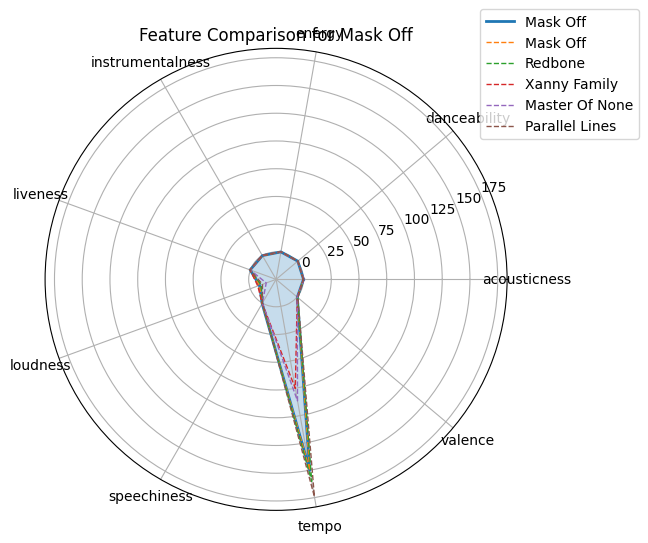

In [56]:
# Example usage
print("Recommendations for 'Mask Off' by Future:")
print(recommend_songs("Mask Off", artist="Future"))
visualize_features("Mask Off", artist="Future")

Dataset loaded successfully.
Top 10 song recommendations for 'Mask Off':
                                                                   song_title           artist  similarity_score
1173                                                                 Mask Off           Future          1.000000
201                                                                     Mercy       Kanye West          0.982592
780                                                                 Hot N*gga    Bobby Shmurda          0.964124
148                                                                     River            Ibeyi          0.932939
267                                                                     River            Ibeyi          0.932939
992   Swerve... the reeping of all that is worthwhile (Noir not withstanding)  Shabazz Palaces          0.932738
1628                                                                 Language  Porter Robinson          0.926302
357                    

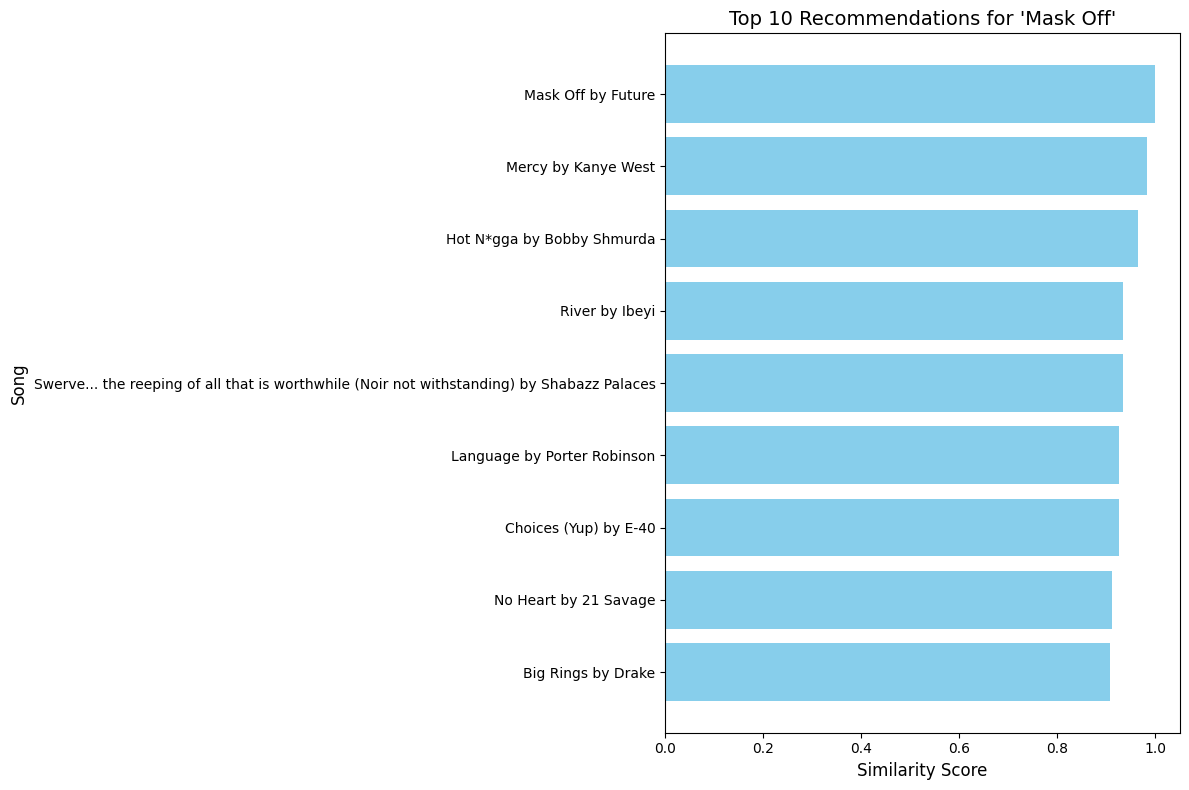

Plot saved as music_recommendations_fixed.png


In [57]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics.pairwise import cosine_similarity
# import matplotlib.pyplot as plt

# --- 1. Load the Dataset ---
try:
    file_path = "music (2).csv"
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure the file is in the same directory.")

# --- 2. Data Preprocessing ---
if 'df' in locals():
    df.dropna(inplace=True)

    # --- 3. Feature Selection & Scaling ---
    features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

    if not all(feature in df.columns for feature in features):
        print("Error: One or more required features are missing from the dataset.")
    else:
        df_features = df[features]
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df_features)
        scaled_df = pd.DataFrame(df_scaled, columns=features)

        # --- 4. Create the Similarity Matrix ---
        cosine_sim = cosine_similarity(scaled_df)
        indices = pd.Series(df.index, index=df['song_title']).drop_duplicates()

        # --- 5. Corrected Recommendation Function ---
        def recommend_songs(title, cosine_sim_matrix, df, indices):
            if title not in indices.index:
                print(f"'{title}' not found in the dataset.")
                return None

            # The fix: Get the first index even if multiple exist
            idx = indices[title].iloc[0] if isinstance(indices[title], pd.Series) else indices[title]

            sim_scores = list(enumerate(cosine_sim_matrix[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

            sim_scores = sim_scores[1:11]
            song_indices = [i[0] for i in sim_scores]

            similar_songs = df.iloc[song_indices].copy()
            similar_songs.loc[:, 'similarity_score'] = [i[1] for i in sim_scores]

            return similar_songs[['song_title', 'artist', 'similarity_score']]

        # --- 6. Get and Display Recommendations ---
        sample_song = "Mask Off"
        recommendations = recommend_songs(sample_song, cosine_sim, df, indices)

        if recommendations is not None:
            print(f"Top 10 song recommendations for '{sample_song}':")
            print(recommendations.to_string())

            # --- 7. Plot the Results ---
            plt.figure(figsize=(12, 8))
            plt.barh(recommendations['song_title'] + ' by ' + recommendations['artist'], recommendations['similarity_score'], color='skyblue')
            plt.xlabel("Similarity Score", fontsize=12)
            plt.ylabel("Song", fontsize=12)
            plt.title(f"Top 10 Recommendations for '{sample_song}'", fontsize=14)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('music_recommendations_fixed.png')
            plt.show()
            print("Plot saved as music_recommendations_fixed.png")